In [1]:
from gym import make
from agent import Agent
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
def plot(log):
    fig, ax = plt.subplots(figsize=(12, 8))
    cfg = (f'alpha: {log["alpha"][0]} | '
           f'gamma: {log["gamma"][0]} | '
           f'eps: {log["eps_max"][0]}, {log["eps_min"][0]} | '
           f'buffer: {log["buffer_size"][0]} | '
           f'batch: {log["batch_size"][0]} | '
           f'tau: {log["tau"][0]} | '
           f'# bin: {log["bins"][0]} | '
           f'sink: {log["to_sink"][0]}')
    ax.set_title(f"Mean reward over 10 episodes @ {cfg}")
    ax.set_xlabel("№ of transitions")
    ax.set_ylabel("Mean reward")

    plt.hlines(90, np.min(log["step"]), np.max(log["step"]),
               colors="r", label="Solved")

    plt.plot(log["step"],
             log["reward_mean"],
             label="DQN_DAS")

    plt.fill_between(log["step"],
                     log["reward_mean"] - log["reward_std"],
                     log["reward_mean"] + log["reward_std"], alpha=0.5)
    plt.legend()
    plt.show()

def collect_data(alpha, gamma, eps_max, eps_min,
                 start_training,
                 buffer_size,
                 batch_size,
                 hidden_size,
                 shaping,
                 tau,
                 num_bins,
                 to_sink):
    env = make("MountainCarContinuous-v0")
    agent = Agent(env,
                  alpha=alpha,
                  gamma=gamma,
                  hidden_size=hidden_size,
                  tau=tau, num_bins=num_bins)
    return agent, pd.DataFrame(agent.train(200_000,
                                           buffer_size=buffer_size,
                                           batch_size=batch_size,
                                           eps_max=eps_max,
                                           eps_min=eps_min,
                                           shaping_coef=shaping,
                                           start_training=start_training,
                                           to_sink=to_sink))

def print_info(log):
    r_max_idx = np.argmax(log["reward_mean"])
    print(f"Max reward {log['reward_mean'][r_max_idx]} @ {log['step'][r_max_idx]}")

step: 200000 | Rmean = 94.4327 | Rstd = 0.9258: 100%|██████████| 200000/200000 [12:58<00:00, 256.86it/s]  


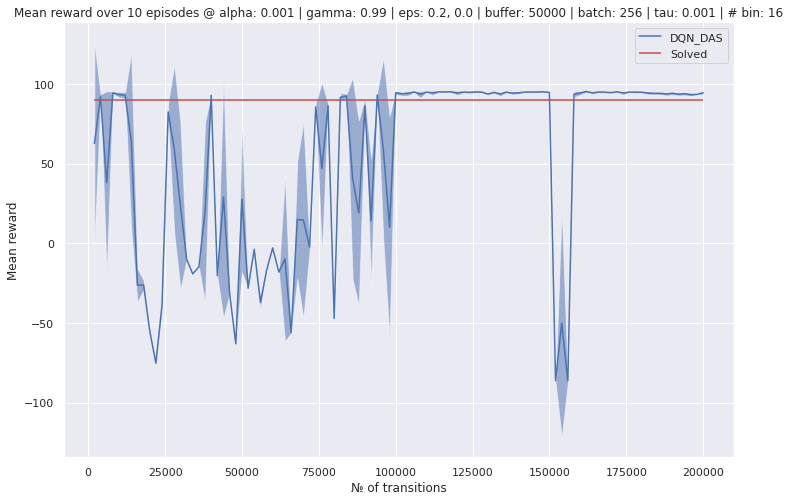

Max reward 95.23633472165979 @ 161999


(94.5818463002581, 0.7305271661348085)

In [3]:
config = {
    "alpha": 1e-3,
    "gamma": 0.99,
    "buffer_size": 50000,
    "batch_size": 256,
    "start_training": 1000,
    "eps_max": 0.2,
    "eps_min": 0.,
    "hidden_size": 32,
    "shaping": 300,
    "tau": 0.001,
    "num_bins": 16,
    "to_sink": False
}

agent, log = collect_data(**config)
plot(log)
print_info(log)
agent.evaluate_policy(100)


Пусть и решение представляет из себя довольно наивную реализацию DQN с soft-update'ом таргет-сетки,
но в целом, кажется, что можно считать, что мы вышли на плато.

Конечно, присутствует некоторая нестабильность.
Мне кажется, что это связано с тем, что несмотря на то, что агент довольно быстро в начале понимает, что нужно делать,
в буффере сохраняется много нежелательного опыта, следовательно, один из вариантов решения этой проблемы: использовать приоретезированный опыт (PER).
Еще можно попробовать сделать совсем агрессивное действие по удалению всего накопленного опыта после первого удачного решения задачи, т.е. достижения награды больше 90.

step: 200000 | Rmean = 94.3183 | Rstd = 0.6575: 100%|██████████| 200000/200000 [13:49<00:00, 240.98it/s] 


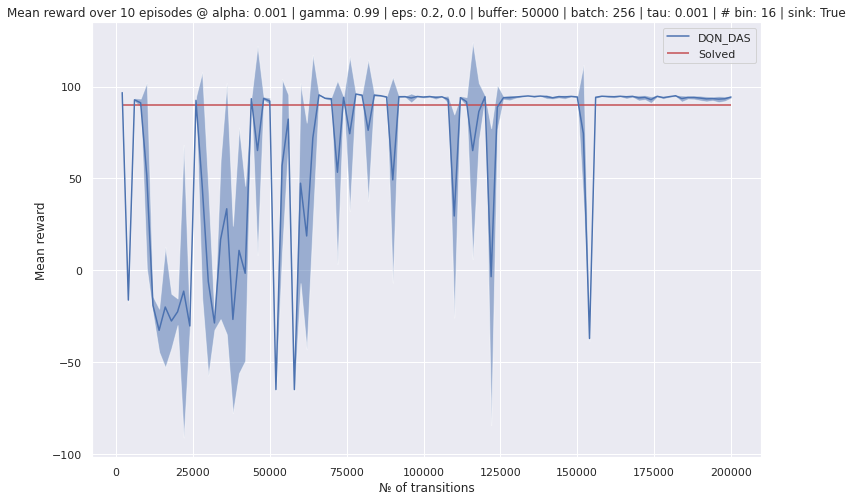

Max reward 96.72160542761722 @ 1999


(94.57856388507398, 0.6001885546359012)

In [3]:
config = {
    "alpha": 1e-3,
    "gamma": 0.99,
    "buffer_size": 50000,
    "batch_size": 256,
    "start_training": 1000,
    "eps_max": 0.2,
    "eps_min": 0.,
    "hidden_size": 32,
    "shaping": 300,
    "tau": 0.001,
    "num_bins": 16,
    "to_sink": True
}

agent, log = collect_data(**config)
plot(log)
print_info(log)
agent.evaluate_policy(100)

Этот эксперимент показывает, что самая простая схема по удалению всего буффера не особо помогает.

